In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.data_loading import load_data
from skrub import MinHashEncoder
from sklearn.decomposition import PCA
from src.utils import FeaturesExtractor, FixedSizeSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from tabpfn import TabPFNClassifier
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import time
from sentence_transformers import SentenceTransformer

In [6]:
%cd lm_tab/scripts

/scratch/lgrinszt/lm_tab/scripts


In [7]:
!pwd

/scratch/lgrinszt/lm_tab/scripts


In [8]:
from src.models import BertAndTabPFN
    

In [45]:
from transformers import BertForSequenceClassification, BertTokenizer, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import accuracy_score
from src.utils import preprocess_input
from icecream import ic

# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx],
            'tabular_data': self.encodings['tabular_data'][idx] if 'tabular_data' in self.encodings.keys() else None
        }
        return item

    def __len__(self):
        return len(self.labels)
    
# copied from huggingface
from torch.optim.lr_scheduler import LambdaLR
import math
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1):
    """ Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, last_epoch)

def evaluate_model(dataloader, model, input_ids_train, attention_mask_train, labels_train, tabular_data_train):
    print("Evaluating model")
    model.eval()
    val_preds, val_labels, val_losses = [], [], []
    with torch.no_grad():
        for batch in dataloader: #TODO: remove the useless for loop
            input_ids_val = batch['input_ids']
            attention_mask_val = batch['attention_mask']
            labels_val = batch['labels']
            if "tabular_data" in batch.keys():
                tabular_data_val = batch["tabular_data"].to('cuda')
            else:
                tabular_data_val = None
            # move the inputs to GPU
            input_ids_val = input_ids_val.to('cuda')
            attention_mask_val = attention_mask_val.to('cuda')
            labels_val = labels_val.to('cuda')
            # concatenate train and val
            #TODO: make sure this is correct, no leak etc
            # maybe safer to create a TabPFNClassifier with the same parameters as the one in BertAndTabPFN
            input_ids = torch.cat((input_ids_train, input_ids_val), axis=0)
            attention_mask = torch.cat((attention_mask_train, attention_mask_val), axis=0)
            labels = torch.cat((labels_train, labels_val), axis=0)
            if tabular_data_train is not None:
                tabular_data = torch.cat((tabular_data_train, tabular_data_val), axis=0)
            else:
                tabular_data = None
            single_eval_pos = len(input_ids_train)
            if single_eval_pos > 1024:
                print("WARNING: single_eval_pos > 1024")
            print(f"Train size: {len(input_ids_train)}, Val size: {len(input_ids_val)}")
            print(f"Single eval pos for evaluation: {single_eval_pos}")
            output = model(input_ids, attention_mask=attention_mask, y=labels, tabular_data=tabular_data, single_eval_pos=single_eval_pos).squeeze()
            val_loss = nn.CrossEntropyLoss()(output, labels[single_eval_pos:].long().reshape(-1))
            val_losses.append(val_loss.cpu())
            preds = torch.argmax(output, axis=-1).cpu().detach().numpy()
            val_preds.append(preds)
            val_labels.append(labels[single_eval_pos:].cpu().detach().numpy().reshape(-1))
        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        loss = np.mean(val_losses)
        accuracy = accuracy_score(val_labels, val_preds)
    
    # try with tabpfn classifier to see if there is a difference
    # tabfn_input_train = model(input_ids_train, attention_mask=attention_mask_train, y=labels_train, single_eval_pos=single_eval_pos, return_tabpfn_input=True).cpu().detach().numpy()
    # clf = model.raw_tabpfn
    # clf.fit(tabfn_input_train, labels_train.cpu().detach().numpy())
    # tabfn_input_val = model(input_ids_val, attention_mask=attention_mask_val, y=labels_val, single_eval_pos=single_eval_pos, return_tabpfn_input=True).cpu().detach().numpy()
    # val_preds = clf.predict(tabfn_input_val)
    # val_labels = labels_val.cpu().detach().numpy()
    # accuracy_clf = accuracy_score(val_labels, val_preds)
    # print(f"Accuracy with tabpfn classifier: {accuracy_clf}")
    # print(f"Accuracy raw: {accuracy}")
    # # move back to cuda

        
    model.train()
    return loss, accuracy
    

def train_model(X_enc_dic, y, n_epochs=20, single_eval_pos_train=500, lr=1e-4,
                prop_train=0.8):

    train_size = int(prop_train * len(X_enc_dic["input_ids"]))
    val_size = len(X_enc_dic["input_ids"]) - train_size
    print(f"Train size: {train_size}, Val size: {val_size} for training")
    X_train, X_val = {k: v[:train_size] for k, v in X_enc_dic.items()}, {k: v[train_size:] for k, v in X_enc_dic.items()}
    y_train, y_val = y[:train_size], y[train_size:]
    train_dataset = CustomDataset(X_train, torch.tensor(y_train).float().reshape(-1, 1))
    val_dataset = CustomDataset(X_val, torch.tensor(y_val).float().reshape(-1, 1))
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)#TODO
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    # Initialize model and optimizer
    #model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    model = BertAndTabPFN(**kwargs).to('cuda')
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    es_patience = 4
    es_tolerance = 1e-4
    es_counter = 0

    # Training loop
    num_epochs = n_epochs
    best_val_loss = np.inf
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(max(num_epochs, 1)): # if num_epochs is 0, we still want to evaluate the model once, but we don't train it
        print("Epoch", epoch + 1)
        if es_counter >= es_patience:
            break
        ###########
        # Train loop
        model.train()
        train_preds, train_labels, train_losses_epoch = [], [], []
        for batch in train_loader:
            input_ids_train = batch['input_ids']
            attention_mask_train = batch['attention_mask']
            labels_train = batch['labels']
            if "tabular_data" in batch:
                tabular_data_train = batch["tabular_data"].to('cuda')
                assert tabular_data_train is not None
            else:
                tabular_data_train = None
            # move the inputs to GPU
            input_ids_train = input_ids_train.to('cuda')
            attention_mask_train = attention_mask_train.to('cuda')
            labels_train = labels_train.to('cuda')
            single_eval_pos = single_eval_pos_train
            print("training, single_eval_pos", single_eval_pos)
            # print(f"Tabular data: {tabular_data_train}")
            # print)
            output = model(input_ids_train, attention_mask=attention_mask_train, y=labels_train, single_eval_pos=single_eval_pos,
                           tabular_data=tabular_data_train).squeeze()
            loss = nn.CrossEntropyLoss()(output, labels_train[single_eval_pos:].long().reshape(-1))
            if num_epochs >= 1:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            # compute train accuracy
            preds = torch.argmax(output, axis=-1).cpu().detach().numpy()
            train_losses_epoch.append(loss.cpu().item())
            train_preds.append(preds)
            train_labels.append(labels_train[single_eval_pos:].cpu().detach().numpy().reshape(-1))
        train_preds = np.concatenate(train_preds)
        train_labels = np.concatenate(train_labels)
        train_loss_epoch = np.mean(train_losses_epoch)
        train_losses.append(train_loss_epoch)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1} - Training loss: {train_loss_epoch}, Training accuracy: {train_accuracy}")

        # Validation loop
        val_loss, val_accuracy = evaluate_model(val_loader, model, input_ids_train, attention_mask_train, labels_train, tabular_data_train)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch + 1} - Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")
        if val_loss < best_val_loss - es_tolerance:
            print(f"Validation loss decreased from {best_val_loss} to {val_loss}")
            best_val_loss = val_loss
            # save the model
            print("Saving model")
            torch.save(model.state_dict(), "checkpoints/model.pt") #TODO: make sure no overlap with other models
            # save input_ids_train, attention_mask_train, labels_train
            #torch.save(input_ids_train, "checkpoints/input_ids_train.pt")
            #torch.save(attention_mask_train, "checkpoints/attention_mask_train.pt")
            #torch.save(labels_train, "checkpoints/labels_train.pt")
        else:
            es_counter += 1
            print(f"Early stopping counter: {es_counter}")
            if es_counter >= es_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Load the best model
    time.sleep(3) # otherwise I have some bugs if the model has just been saved
    model.load_state_dict(torch.load("checkpoints/model.pt"))
    #input_ids_train = torch.load("checkpoints/input_ids_train.pt")
    #attention_mask_train = torch.load("checkpoints/attention_mask_train.pt")
    #labels_train = torch.load("checkpoints/labels_train.pt")
    # concatenate train and val
    for batch in val_loader: #TODO: this won't work when I take lower batch sizes
        input_ids_val = batch['input_ids']
        attention_mask_val = batch['attention_mask']
        labels_val = batch['labels']
        if "tabular_data" in X_val:
            tabular_data_val = X_val["tabular_data"].to('cuda')
        else:
            tabular_data_val = None
        # move the inputs to GPU
        input_ids_val = input_ids_val.to('cuda')
        attention_mask_val = attention_mask_val.to('cuda')
        labels_val = labels_val.to('cuda')
        # concatenate train and val
    input_ids = torch.cat((input_ids_train, input_ids_val), axis=0)
    attention_mask = torch.cat((attention_mask_train, attention_mask_val), axis=0)
    labels = torch.cat((labels_train, labels_val), axis=0)
    tabular_data = torch.cat((tabular_data_train, tabular_data_val), axis=0)



    return model, input_ids, attention_mask, labels, tabular_data, train_losses, train_accuracies, val_losses, val_accuracies #TODO use a dictionary instead of returning all these variables




# With numerical data

In [41]:
#TODO create a function to run with submitit

## Finding the right max length

In [42]:
# transformer_name = "distilroberta-base"
# tokenizer = AutoTokenizer.from_pretrained(transformer_name)
# #datasets = ["journal_jcr_cls", "movies", "michelin", "spotify", "employee_salary", "museums", "fifa_footballplayers_22", "jp_anime"]
# datasets = ["journal_jcr_cls", "spotify", "museums", "employee_salary"]

# for dataset in datasets:
#     test_losses = []
#     test_accuracies = []
#     train_losses_setting = [] # for this config
#     train_accuracies_setting = []
#     val_losses_setting = []
#     val_accuracies_setting = []

#     X_text, X_rest, y = load_data(dataset, max_rows=10000, include_all_columns=True)
#     # label encoding
#     #y = y.astype('category').cat.codes
#     y = y.astype(np.int64)
#     texts = X_text.tolist()
#     all_encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
#     print(all_encoding["input_ids"].shape)
#     # print the non-padded length median and quantiles
#     non_padded_lengths = np.sum(all_encoding["attention_mask"].numpy(), axis=1)
#     max_length = np.quantile(non_padded_lengths, 0.95)
#     all_encoding = tokenizer(texts, padding="max_length", truncation=True, max_length=int(max_length), return_tensors="pt")
#     print(all_encoding["input_ids"].shape)
#     print("-------------")


In [50]:
from src.utils import FixedSizeSplit
import pandas as pd
from skrub import TableVectorizer
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
cv = FixedSizeSplit(n_splits=5, n_train=1000, n_test=2000, random_state=42)
transformer_name = "sentence-transformers/all-distilroberta-v1"
tokenizer = AutoTokenizer.from_pretrained(transformer_name)
#datasets = ["journal_jcr_cls", "movies", "michelin", "spotify", "employee_salary", "museums", "fifa_footballplayers_22", "jp_anime"]
datasets = ["journal_jcr_cls", "spotify", "museums", "employee_salary"]
results = pd.DataFrame(columns=["dataset", "encoding", "dim_reduction", "model", "accuracy", "numerical_transformer", "lr", "single_eval_pos_train", "dim_tabpfn", "n_epochs"])
#results = pd.read_csv("results_training_with_numerics_new.csv")
all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []
all_test_losses = []
all_test_accuracies = []
for numerical_transformer_name in ["passthrough"]:#, "power_transformer"]:
    if numerical_transformer_name == "passthrough":
        numerical_transformer = "passthrough"
    elif numerical_transformer_name == "power_transformer":
        numerical_transformer = PowerTransformer(standardize=True)

    rest_trans = TableVectorizer(high_card_cat_transformer=MinHashEncoder(n_components=10),
        low_card_cat_transformer=OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), #TODO: not sure about this
        numerical_transformer=numerical_transformer,
        cardinality_threshold=10)
    for lr in [1e-5]:
        for single_eval_pos_train in [400]:
            for dim_tabpfn in [30]:
                for n_epochs in [10, 0]:
                    for disable_dropout in [False]:
                        for dimension_reduction in ["pca"]:
                            for embedding_strategy in ["mean_pooling"]:
                                for n_epoch_per_gradient in [10, 3, 1]:
                                    model_config = {"transformer_name": transformer_name, "dim_tabpfn": dim_tabpfn,
                                                    "disable_dropout": disable_dropout, "dimension_reduction": dimension_reduction, "embedding_strategy": embedding_strategy,
                                                    "preprocess_before_tabpfn": True, "lora": False, "train_tabpfn": False}
                                    for prop_train in [0.8]:
                                        for dataset in datasets:
                                            test_losses = []
                                            test_accuracies = []
                                            train_losses_setting = [] # for this config
                                            train_accuracies_setting = []
                                            val_losses_setting = []
                                            val_accuracies_setting = []
                                            #TODO same tokenization than SentenceTransformer
                                            X_text, X_rest, y = load_data(dataset, max_rows=10000, include_all_columns=True)
                                            # label encoding
                                            #y = y.astype('category').cat.codes
                                            y = y.astype(np.int64)
                                            texts = X_text.tolist()
                                            all_encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
                                            # print the non-padded length median and quantiles
                                            non_padded_lengths = np.sum(all_encoding["attention_mask"].numpy(), axis=1)
                                            max_length = np.quantile(non_padded_lengths, 0.95)
                                            all_encoding = tokenizer(texts, padding="max_length", truncation=True, max_length=int(max_length), return_tensors="pt")


                                            for train_index, test_index in cv.split(X_rest, y):
                                                X_enc_train, X_enc_test = {k: v[train_index] for k, v in all_encoding.items()}, {k: v[test_index] for k, v in all_encoding.items()}
                                                y_train, y_test = y[train_index], y[test_index]
                                                X_rest_train, X_rest_test = X_rest.iloc[train_index], X_rest.iloc[test_index]

                                                # encode the rest
                                                X_rest_train = rest_trans.fit_transform(X_rest_train)
                                                X_rest_test = rest_trans.transform(X_rest_test)
                                                # convert to tensors
                                                X_rest_train = torch.tensor(X_rest_train).float()
                                                X_rest_test = torch.tensor(X_rest_test).float()
                                                # concatenate the two
                                                X_train = {**X_enc_train, **{"tabular_data": X_rest_train}}
                                                X_test = {**X_enc_test, **{"tabular_data": X_rest_test}}
                                                #model, input_ids_train, attention_mask_train, labels_train = train_model(X_train, y_train, transformer_name=transformer_name)
                                                model, input_ids_train, attention_mask_train, labels_train, tabular_data_train, train_losses, train_accuracies, val_losses, val_accuracies = train_model(X_train, y_train, n_epochs=n_epochs, lr=lr, single_eval_pos_train=single_eval_pos_train, prop_train=prop_train,
                                                                                                                                                                                                         n_epoch_per_gradient=n_epoch_per_gradient,
                                                                                                                                                                                                        **model_config)
                                                all_train_losses.append(train_losses)
                                                all_val_losses.append(val_losses)
                                                all_train_accuracies.append(train_accuracies)
                                                all_val_accuracies.append(val_accuracies)
                                                train_losses_setting.append(train_losses)
                                                train_accuracies_setting.append(train_accuracies)
                                                val_losses_setting.append(val_losses)
                                                val_accuracies_setting.append(val_accuracies)
                                                print("Finished training")
                                                # Evaluate on test set
                                                # create a test dataset
                                                

                                                test_dataset = CustomDataset(X_test, torch.tensor(y_test).float().reshape(-1, 1))
                                                test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
                                                test_loss, test_accuracy = evaluate_model(test_loader, model, input_ids_train, attention_mask_train, labels_train, tabular_data_train)
                                                print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
                                                test_losses.append(test_loss)
                                                test_accuracies.append(test_accuracy)
                                                del input_ids_train, attention_mask_train, labels_train, model, tabular_data_train
                                                torch.cuda.empty_cache()
                                            # print memory usage
                                            #print(torch.cuda.memory_summary(device=None, abbreviated=False))
                                            res = {"dataset": [dataset] * 5, "encoding": [f"bert_{numerical_transformer_name}"] * 5, "model": [f"{transformer_name}_tabpfn_lora"] * 5, 
                                                                                        "numerical_transformer": [numerical_transformer_name] * 5, "lr": [lr] * 5, "single_eval_pos_train": [single_eval_pos_train] * 5, "n_epochs": [n_epochs] * 5,
                                                                                        "n_epoch_per_gradient": [n_epoch_per_gradient] * 5,
                                                                                        "prop_train": [prop_train] * 5, 
                                                                                        "train_loss": train_losses_setting.copy(), "train_accuracy": train_accuracies_setting.copy(),
                                                                                        "val_loss": val_losses_setting.copy(), "val_accuracy": val_accuracies_setting.copy(), "test_loss": test_losses.copy(),
                                                                                        "accuracy": test_accuracies.copy()}
                                            res.update(model_config)
                                            results = pd.concat([results, pd.DataFrame(res)])
                                            results.to_csv("results_training_with_numerics_epoch_per_gradient.csv", index=False)

Original task: classification for journal_jcr_cls
Removed 0 columns with missing values on 4 columns
Removed 485 rows with missing values on 5710 rows
Removed 485 rows with missing values on 5710 rows
Removed 0 columns with missing values on 4 columns
New shape: (5225, 4)
X_text shape: (5225,), X_rest shape: (5225, 4), y shape: (5225,)
Train size: 800, Val size: 200 for training
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Epoch 1
training, single_eval_pos 400
Using additional tabular data of shape torch.Size([800, 31])
Epoch 1 - Training loss: 0.669478178024292, Training accuracy: 0.595
Evaluating model
Train size: 800, Val size: 200
Single eval pos for evaluation: 800
Using additional tabular data of shape torch.Size([1000, 31])
Epoch 1 - Validation loss: 0.7029833197593689, Validation accuracy: 0.53
Validation loss decreased from inf to 0.7029833197593689
Saving model
Epoch 2
training, single_eval_pos 400
Using additional tabular data

KeyboardInterrupt: 

In [3]:
import pandas as pd

In [48]:
results

,dataset,encoding,dim_reduction,model,accuracy,numerical_transformer,lr,single_eval_pos_train,dim_tabpfn,n_epochs,...,val_loss,val_accuracy,test_loss,transformer_name,disable_dropout,dimension_reduction,embedding_strategy,preprocess_before_tabpfn,lora,train_tabpfn
0,journal_jcr_cls,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.5600,passthrough,0.00001,400,10,0,...,[0.69864976],[0.535],0.683756,sentence-transformers/all-distilroberta-v1,False,pca,mean_pooling,True,False,False
1,journal_jcr_cls,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.5840,passthrough,0.00001,400,10,0,...,[0.6631319],[0.62],0.669742,sentence-transformers/all-distilroberta-v1,False,pca,mean_pooling,True,False,False
2,journal_jcr_cls,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.5590,passthrough,0.00001,400,10,0,...,[0.65712875],[0.635],0.684241,sentence-transformers/all-distilroberta-v1,False,pca,mean_pooling,True,False,False
3,journal_jcr_cls,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.5825,passthrough,0.00001,400,10,0,...,[0.68104315],[0.565],0.674868,sentence-transformers/all-distilroberta-v1,False,pca,mean_pooling,True,False,False
4,journal_jcr_cls,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.5780,passthrough,0.00001,400,10,0,...,[0.68454766],[0.555],0.678132,sentence-transformers/all-distilroberta-v1,False,pca,mean_pooling,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,employee_salary,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.9105,passthrough,0.00001,600,35,10,...,"[0.19602793, 0.19554706, 0.19674593, 0.1958671...","[0.905, 0.915, 0.915, 0.92, 0.92, 0.92]",0.212940,sentence-transformers/all-distilroberta-v1,True,linear,mean_pooling,True,False,False
1436,employee_salary,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.9045,passthrough,0.00001,600,35,10,...,"[0.22276445, 0.22695594, 0.23255458, 0.2378468...","[0.91, 0.91, 0.915, 0.915, 0.92]",0.217309,sentence-transformers/all-distilroberta-v1,True,linear,mean_pooling,True,False,False
1437,employee_salary,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.9155,passthrough,0.00001,600,35,10,...,"[0.20164019, 0.20460421, 0.20829621, 0.2096572...","[0.91, 0.9, 0.9, 0.9, 0.9]",0.199332,sentence-transformers/all-distilroberta-v1,True,linear,mean_pooling,True,False,False
1438,employee_salary,bert_passthrough,NaN,sentence-transformers/all-distilroberta-v1_tab...,0.9065,passthrough,0.00001,600,35,10,...,"[0.28902552, 0.288173, 0.28464746, 0.2795413, ...","[0.905, 0.9, 0.9, 0.91, 0.91, 0.925, 0.935, 0....",0.243185,sentence-transformers/all-distilroberta-v1,True,linear,mean_pooling,True,False,False


In [ ]:
#results = pd.read_csv("results_training_with_numerics.csv")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


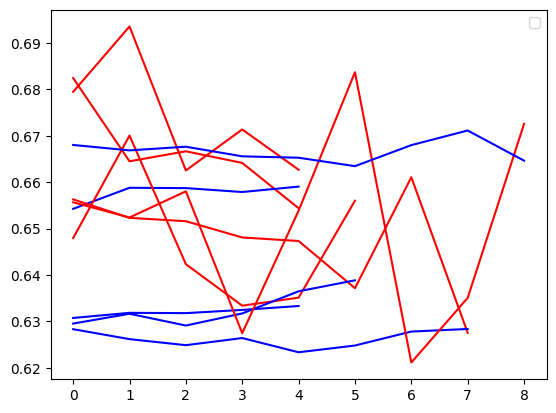

In [45]:
import matplotlib.pyplot as plt
results_to_plot = results[results["n_epochs"] == 10]
results_to_plot = results_to_plot[results_to_plot["dataset"] == "museums"]
for i in range(len(results_to_plot)):
    plt.plot(eval(results_to_plot.iloc[i]["train_loss"]), color="red")
    plt.plot(eval(results_to_plot.iloc[i]["val_loss"]), color="blue")
plt.legend()
plt.show()

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
##df = pd.read_csv("../results/results.csv")


# add new rows with test accuracies
#new_rows = {"dataset": ["spotify"] * 5, "model": ["bert"] * 5, "dim_reduction": ["none"] * 5, "encoding": ["lm__all-MiniLM-L12-v2"] * 5, "accuracy": test_accuracies}
#df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
cols_to_consider = ['dataset', 'model', 'encoding', "numerical_transformer", "lr", "single_eval_pos_train", "dim_tabpfn", "n_epochs",
                                  "prop_train", "disable_dropout", "dimension_reduction"]
results_ = results[cols_to_consider + ["accuracy"]]
melted_results = results_.groupby(cols_to_consider).mean().reset_index()

hue_var = "n_epochs"
fig = px.strip(
    data_frame=melted_results,
    x="accuracy",
    y="dataset",
    color=hue_var,
    #color="dim_reduction",
    facet_row="dimension_reduction",
    hover_data=cols_to_consider,
    title="Swarm Plot of Model Accuracies Across Datasets",
    labels={"accuracy": "Accuracy", "dataset": "Dataset", "model": "Model"},
    height=1000,
    width=900,
)

fig.show()

In [ ]:
import matplotlib.pyplot as plt
for i in range(len(all_train_losses)):
    plt.plot(all_train_losses[i], label="train")
    plt.plot(all_val_losses[i], label="val")
    plt.hlines(test_losses[i], 0, len(all_train_losses[i]), label="test", linestyle="dashed")
    plt.legend()
    plt.show()
    plt.plot(all_train_accuracies[i], label="train acc")
    plt.plot(all_val_accuracies[i], label="val acc")
    plt.hlines(test_accuracies[i], 0, len(all_val_accuracies[i]), label="test acc", linestyle="dashed")
    plt.legend()
    plt.show()

# Only text

In [ ]:
from src.utils import FixedSizeSplit
import pandas as pd
cv = FixedSizeSplit(n_splits=5, n_train=1000, n_test=4000)
transformer_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(transformer_name)
datasets = ["journal_jcr_cls", "movies", "michelin", "spotify", "employee_salary", "museums", "fifa_footballplayers_22", "jp_anime"]
results = pd.DataFrame(columns=["dataset", "encoding", "dim_reduction", "model", "accuracy"])
for dataset in datasets:
    test_losses = []
    test_accuracies = []
    X, y = load_data(dataset, max_rows=10000
    # label encoding
    #y = y.astype('category').cat.codes
    y = y.astype(np.int64)
    texts = X.tolist()
    all_encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = {k: v[train_index] for k, v in all_encoding.items()}, {k: v[test_index] for k, v in all_encoding.items()}
        y_train, y_test = y[train_index], y[test_index]
        #model, input_ids_train, attention_mask_train, labels_train = train_model(X_train, y_train, transformer_name=transformer_name)
        model, input_ids_train, attention_mask_train, labels_train = train_model(X_train, y_train, transformer_name=transformer_name)
        print("Finished training")
        # Evaluate on test set
        # create a test dataset
        

        test_dataset = CustomDataset(X_test, torch.tensor(y_test).float().reshape(-1, 1))
        test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
        test_loss, test_accuracy = evaluate_model(test_loader, model, input_ids_train, attention_mask_train, labels_train)
        print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        del input_ids_train, attention_mask_train, labels_train, model
        torch.cuda.empty_cache()
    # print memory usage
    #print(torch.cuda.memory_summary(device=None, abbreviated=False))
    
    results = pd.concat([results, pd.DataFrame({"dataset": [dataset] * 5, "encoding": ["bert"] * 5, "dim_reduction": ["none"] * 5, "model": ["bert"] * 5, "accuracy": test_accuracies.copy()})])
    results.to_csv("results_training.csv", index=False)

In [ ]:
print(test_accuracies)

In [ ]:
%cd lm_tab/scripts

In [ ]:
#show column singe_eval_pos_train
df

In [ ]:
df

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
#df = pd.read_csv("../results/results.csv")
#df = pd.read_csv("results_with_numerics.csv")
df = pd.read_csv("results_tabfn_basic.csv")
print(df["model"].unique())
df_new = pd.read_csv("results_training_with_numerics.csv")
df_new_bis = pd.read_csv("results_training_with_numerics_lora.csv")
default_values = {"n_epochs": 1, 
                    "lr": 1e-5,
                    "single_eval_pos_train": 500,
                    "dim_tabpfn": 20,
                    "numerical_transformer": "passthrough"}
to_vary = "n_epochs"
for col_name, default_value in default_values.items():
    if col_name == to_vary:
        continue
    df_new = df_new[df_new[col_name] == default_value]
#df_new = pd.read_csv("results_training.csv")
#df = df[df["dataset"] == "spotify"]
df = pd.concat([df, df_new, df_new_bis], ignore_index=True)
# replace nans with "missing" for all columns
df = df.fillna("missing")

# add new rows with test accuracies
#new_rows = {"dataset": ["spotify"] * 5, "model": ["bert"] * 5, "dim_reduction": ["none"] * 5, "encoding": ["lm__all-MiniLM-L12-v2"] * 5, "accuracy": test_accuracies}
#df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
melted_results = df.groupby(['dataset', 'model', 'dim_reduction', 'encoding', "numerical_transformer", "lr", "single_eval_pos_train", "dim_tabpfn", "n_epochs"]).mean().reset_index()
#melted_results = results.explode('accuracy')
#melted_results['accuracy'] = melted_results['accuracy'].astype(float)
#melted_results = melted_results[melted_results['encoding'] == 'lm__all-MiniLM-L12-v2']


# Creating the swarmplot
# plt.figure(figsize=(15, 20))
# sns.swarmplot(data=melted_results, x='accuracy', y='dataset', hue='model', dodge=True)
# plt.title('Swarm Plot of Model Accuracies Across Datasets')
# plt.xlabel('Accuracy')
# plt.ylabel('Dataset')
# plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()
# Create the plot
#hue_var = to_vary
hue_var = "model"
fig = px.strip(
    data_frame=melted_results,
    x="accuracy",
    y="dataset",
    color=hue_var,
    #color="dim_reduction",
    title="Swarm Plot of Model Accuracies Across Datasets",
    labels={"accuracy": "Accuracy", "dataset": "Dataset", "model": "Model"},
    height=600,
    width=900,
)

# Update hover information for each trace (grouped by 'color' or 'model' in this case)
for i, trace in enumerate(fig.data):
    subset_df = melted_results[melted_results[hue_var] == trace.name]
    hover_template = "<br>".join([f"{col}: %{{customdata[{i}]}}" for i, col in enumerate(subset_df.columns)])
    trace.customdata = subset_df.values
    trace.hovertemplate = hover_template

fig.show()

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoModel
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoModel
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
model_name_or_path = "distilroberta-base"
tokenizer_name_or_path = "distilroberta-base"

peft_config = LoraConfig(inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
)

model = AutoModel.from_pretrained(model_name_or_path)
print("Loaded model")
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import accuracy_score
from src.utils import preprocess_input

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

# Your text data and labels (replace these with your actual data and labels)
# Your text data and labels (replace these with your actual data and labels)
#texts = X_original[column_to_consider].tolist()
texts = X.tolist()
#labels = (y_original > np.median(y_original)).tolist()
#labels = y_original.tolist()
labels = y.tolist()

# Tokenize the text data
#encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Create a custom dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset and dataloaders
#dataset = CustomDataset(encoding, torch.tensor(labels).float().reshape(-1, 1))
#print(f"Dataset size: {len(dataset)}")
train_size = 700
val_size = 1000 #TODO

all_encoding = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
encoding_train = {k: v[:train_size] for k, v in all_encoding.items()}
encoding_val = {k: v[train_size:train_size+val_size] for k, v in all_encoding.items()}
encoding_test = {k: v[train_size+val_size:] for k, v in all_encoding.items()}
train_dataset = CustomDataset(encoding_train, torch.tensor(labels).float().reshape(-1, 1)[:train_size])
val_dataset = CustomDataset(encoding_val, torch.tensor(labels).float().reshape(-1, 1)[train_size:train_size+val_size])
test_dataset = CustomDataset(encoding_test, torch.tensor(labels).float().reshape(-1, 1)[train_size+val_size:])
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Initialize model and optimizer
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model = BertAndTabPFN(preprocess_before_tabpfn=True, linear_translator=False).to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

es_patience = 5
es_tolerance = 1e-4
es_counter = 0

# Training loop
num_epochs = 20
best_val_loss = np.inf
for epoch in range(num_epochs):
    if es_counter >= es_patience:
        break
    ###########
    # Train loop
    model.train()
    train_preds, train_labels, train_losses = [], [], []
    for batch in train_loader:
        input_ids_train = batch['input_ids']
        attention_mask_train = batch['attention_mask']
        labels_train = batch['labels']
        # move the inputs to GPU
        input_ids_train = input_ids_train.to('cuda')
        attention_mask_train = attention_mask_train.to('cuda')
        labels_train = labels_train.to('cuda')
        single_eval_pos = 400
        output = model(input_ids_train, attention_mask=attention_mask_train, y=labels_train, single_eval_pos=single_eval_pos).squeeze()
        loss = nn.CrossEntropyLoss()(output, labels_train[single_eval_pos:].long().reshape(-1))
        if epoch > 0:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # compute train accuracy
        preds = torch.argmax(output, axis=-1).cpu().detach().numpy()
        #train_accuracy = accuracy_score(labels_train[single_eval_pos:].cpu().detach().numpy().reshape(-1), preds)
        #print(f"Epoch {epoch + 1} - Training loss: {loss}, Training accuracy: {train_accuracy}")
        train_losses.append(loss.cpu().item())
        train_preds.append(preds)
        train_labels.append(labels_train[single_eval_pos:].cpu().detach().numpy().reshape(-1))
    train_preds = np.concatenate(train_preds)
    train_labels = np.concatenate(train_labels)
    train_losses = np.mean(train_losses)
    print(f"Epoch {epoch + 1} - Training loss: {train_losses}, Training accuracy: {accuracy_score(train_labels, train_preds)}")
    # Validation loop
    model.eval()
    val_preds, val_labels, val_losses = [], [], []
    with torch.no_grad():
        for batch in val_loader: #TODO: remove the useless for loop
            input_ids_val = batch['input_ids']
            attention_mask_val = batch['attention_mask']
            labels_val = batch['labels']
            # move the inputs to GPU
            input_ids_val = input_ids_val.to('cuda')
            attention_mask_val = attention_mask_val.to('cuda')
            labels_val = labels_val.to('cuda')
            # concatenate train and val
            #TODO: make sure this is correct, no leak etc
            # maybe safer to create a TabPFNClassifier with the same parameters as the one in BertAndTabPFN
            input_ids = torch.cat((input_ids_train, input_ids_val), axis=0)
            attention_mask = torch.cat((attention_mask_train, attention_mask_val), axis=0)
            labels = torch.cat((labels_train, labels_val), axis=0)
            single_eval_pos = train_size
            output = model(input_ids, attention_mask=attention_mask, y=labels, single_eval_pos=single_eval_pos).squeeze()
            val_loss = nn.CrossEntropyLoss()(output, labels[single_eval_pos:].long().reshape(-1))
            if val_loss < best_val_loss - es_tolerance:
                print(f"Validation loss decreased from {best_val_loss} to {val_loss}")
                best_val_loss = val_loss
                # save the model
                torch.save(model.state_dict(), "checkpoints/model.pt")
                # save input_ids_train, attention_mask_train, labels_train
                torch.save(input_ids_train, "checkpoints/input_ids_train.pt")
                torch.save(attention_mask_train, "checkpoints/attention_mask_train.pt")
                torch.save(labels_train, "checkpoints/labels_train.pt")
            else:
                es_counter += 1
                print(f"Early stopping counter: {es_counter}")
                if es_counter >= es_patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break


            val_losses.append(val_loss.cpu())
            preds = torch.argmax(output, axis=-1).cpu().detach().numpy()
            val_preds.append(preds)
            val_labels.append(labels[single_eval_pos:].cpu().detach().numpy().reshape(-1))
        else:
            val_preds = np.concatenate(val_preds)
            val_labels = np.concatenate(val_labels)
            val_losses = np.mean(val_losses)
            print(f"Epoch {epoch + 1} - Validation loss: {val_losses}")
            # Compute accuracy
            val_accuracy = accuracy_score(val_labels, val_preds)
            print(f"Epoch {epoch + 1} - Validation accuracy: {val_accuracy}")

# Load the best model
model.load_state_dict(torch.load("checkpoints/model.pt"))
input_ids_train = torch.load("checkpoints/input_ids_train.pt")
attention_mask_train = torch.load("checkpoints/attention_mask_train.pt")
labels_train = torch.load("checkpoints/labels_train.pt")

# Test loop
model.eval()
test_preds, test_labels, test_losses = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids_test = batch['input_ids']
        attention_mask_test = batch['attention_mask']
        labels_test = batch['labels']
        # move the inputs to GPU
        input_ids_test = input_ids_test.to('cuda')
        attention_mask_test = attention_mask_test.to('cuda')
        labels_test = labels_test.to('cuda')
        # concatenate train and val
        #TODO put this back
        #input_ids = torch.cat((input_ids_train, input_ids_test), axis=0)
        #attention_mask = torch.cat((attention_mask_train, attention_mask_test), axis=0)
        #labels = torch.cat((labels_train, labels_test), axis=0)
        single_eval_pos = train_size

        output = model(input_ids_test, attention_mask=attention_mask_test, y=labels_test, single_eval_pos=single_eval_pos).squeeze()
        test_loss = nn.CrossEntropyLoss()(output, labels_test[single_eval_pos:].long().reshape(-1))
        test_losses.append(test_loss.cpu())
        preds = torch.argmax(output, axis=-1).cpu().detach().numpy()
        test_preds.append(preds)
        test_labels.append(labels_test[single_eval_pos:].cpu().detach().numpy().reshape(-1))

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)
test_losses = np.mean(test_losses)
print(f"Test loss: {test_losses}")
print(f"Test accuracy: {accuracy_score(test_labels, test_preds)}")

# Save the model
# model.save_pretrained("./fine_tuned_bert")


In [ ]:
torch.save(input_ids_train, "checkpoints/input_ids_train.pt")

In [ ]:
print(2)

In [ ]:
!ls